# Prioritize candidate genes related to two gene sets 


** Brin Rosenthal (sbrosenthal@ucsd.edu) **

******************

<a id='toc'></a>
### Table of Contents
- [Notebook Summary](#summary)   
- [Step 0: Import useful packages](#import)
- [Step 1: Select background interactome for network propagation](#select_interactome)  
- [Step 2: Load background interactome](#load_interactome)   
    - [Load Multinet interactome](#load_multinet)
    - [Load Menche interactome](#load_menche)
- [Step 3: Load gene sets for network propagation](#load_gene_sets)  
    - [Overlap between gene sets and selected interactome](#disease_interactome_overlap)
- [Step 4: Methods of Localization](#localization)   
    - [Largest Connected Component](#loc_LCC)
    - [Shortest Path Length Distributions](#loc_SPL)
    - [Jaccard Similarity](#loc_jaccard)
    - [Network Propagation](#loc_net_prop)
- [Step 5: Gene Prioritization](#gene_prioritization)  
    - [Gene set intersection](#gene_set_overlap)
    - [Plot prioritized genes in heat-vector space](#visualize_heat_space)
    - [Z-score comparison to edge-shuffled baseline](#zscore_gene_prioritization)
    - [Plot prioritized genes in z-score space](#zscore_plot)
    - [Prepare and save results file](#prep_results_file)
- [Step 6: Visualize hot sub-network](#visualize_hot_subnetwork)
    - [Enrich hot sub-network for Gene Ontology terms](#hot_GO)


*****************

<a id='summary'></a>
## Notebook Summary

Use network propagation methods to:

- Establish how localized in the network are genes that cause two focal diseases (example here: Autism and Epilepsy)

- Place new genes (e.g. a list of mutated genes in a patient cohort) in the space between the two diseases, to establish if these new genes form a link between the two diseases.
    - ** NOTE ** The mutation list included here is a random selection of genes that should not be related to Autism or Epilepsy.  If interested in drawing conclusions, user should replace example gene sets here with a real list of mutations from a patient cohort.

- Prioritize gene candidates from this list of mutated genes

We will be using network data from two published sources:
    - Menche, Jörg, et al. "Uncovering disease-disease relationships through the incomplete interactome." Science 347.6224 (2015): 1257601.
    - Khurana, Ekta, et al. "Interpretation of genomic variants using a unified biological network approach." PLoS Comput Biol 9.3 (2013): e1002886.
    
    
Our methods are also similar to those in this paper (TieDIE):
    - Paull, Evan O., et al. "Discovering causal pathways linking genomic events to transcriptional states using Tied Diffusion Through Interacting Events (TieDIE)." Bioinformatics 29.21 (2013): 2757-2764.






<a id='import'></a>
## Step 0: Import some useful packages

separation.py and localization.py have been modified slightly from the Menche et. al. paper to allow for calculation of significance between disease pairs.

Also import:
    - plotting_results, where I've stored some functions for plotting the results of the analysis
    - network_prop, where we keep the functions related to network propagation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
import pandas as pd
import random
import scipy

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

import sys
code_path = '../source/'
sys.path.append(code_path)
import separation
import localization
import plotting_results
import network_prop

import imp
imp.reload(separation)
imp.reload(localization)
imp.reload(plotting_results)
imp.reload(network_prop)


% matplotlib inline

ImportError: No module named mygene

<a id='select_interactome'></a>
# Step 1: Select background interactome for network propagation


- We will choose between three background interactomes which have been curated in the literature (described below)

<img src="screenshots/which_interactome.png" width="800" height="800">



[TOC](#toc)

<a id='load_interactome'></a>
# Step 2: Load the background interactomes and gene lists

<a id='load_multinet'></a>
### Load and process Multinet (from Gerstein lab)

In [2]:
def load_multinet(path_to_file,translate_to_entrez=True):
    MN_df = pd.read_csv(path_to_file,sep='\t')
    
    if translate_to_entrez:
        genes_unique = []
        genes_unique.extend(MN_df['Gene1'])
        genes_unique.extend(MN_df['Gene2'])
        genes_unique = np.unique(genes_unique)
        genesMN_entrez = mg.querymany(genes_unique, scopes='symbol', fields='entrezgene', species='human')
        
        MN_entrez = [str(x['entrezgene']) for x in genesMN_entrez if 'entrezgene' in x.keys()]
        MN_name = [str(x['query']) for x in genesMN_entrez if 'entrezgene' in x.keys()]
        MN_map = dict(zip(MN_name,MN_entrez))
        
        print('mapping from gene names to entrez ids...')
        MN_g1 = [MN_map[x] for x in MN_df['Gene1'] if x in MN_map.keys()]
        MN_g2 = [MN_map[x] for x in MN_df['Gene2'] if x in MN_map.keys()]
        
        edge_list_MN = zip(MN_g1,MN_g2)
        G_MN = nx.Graph()
        G_MN.add_edges_from(edge_list_MN)
        
    else:
        edge_list_MN = zip(MN_df['Gene1'],MN_df['Gene2'])
        G_MN = nx.Graph()
        G_MN.add_edges_from(edge_list_MN)
        
    return G_MN

<a id='load_menche'></a>
### Load the interactome from Menche et al paper

In [3]:
path_to_file = '../data/Multinet.interactions.txt'
G_MN = load_multinet(path_to_file,translate_to_entrez=True)
print(G_MN.nodes()[0:10])

IOError: File ../data/Multinet.interactions.txt does not exist

In [7]:
# load the interactome network (use their default network)
G_barabasi = separation.read_network('../data/DataS1_interactome.tsv')
# remove self links
separation.remove_self_links(G_barabasi)

# Get rid of nodes with no edges
nodes_degree = G_barabasi.degree()
nodes_0 = [n for n in nodes_degree.keys() if nodes_degree[n]==0]
G_barabasi.remove_nodes_from(nodes_0)


> done loading network:
> network contains 13460 nodes and 141296 links


# Select focal interactome

In [18]:
Gint = G_barabasi # select focal network
int_name = 'Menche'

[TOC](#toc)

<a id='load_gene_sets'></a>
# Step 3: Load gene sets for network propagation

- Select Autism and Epilepsy as two example diseases
- Pull known genes related to both diseases from publicly available databases:    

**Autism**:  Simons Foundation for Autism Research Initiative (SFARI, https://sfari.org/)
    
<img src="screenshots/SFARI.jpg" width="800" height="800">
    
    
** Epilepsy**:  Epilepsy Gene Database (http://61.152.91.49/EpilepsyGene/)
    
<img src="screenshots/EpilepsyGene.jpg" width="800" height="800">

In [8]:
# load SFARI genes
genes_sfari = pd.read_csv('SFARI_autism_genes_20160217.txt',header=None)
genes_sfari = set(genes_sfari[0])


In [9]:
# load Epilepsy genes from EpilepsyGene Database
genes_EPI = pd.read_csv('full_epilepsy_genes.txt')
genes_EPI = list(genes_EPI['Gene symbol'])
epi_entrez = mg.querymany(genes_EPI,scopes='symbol',fields='entrezgene',species='human')
genes_EPI = [str(x['entrezgene']) for x in epi_entrez if 'entrezgene' in x.keys()]


querying 1-499...done.
Finished.
3 input query terms found dup hits:
	[(u'ANKRD20A9P', 3), (u'NKAIN3', 2), (u'AOX2P', 2)]
6 input query terms found no hit:
	[u'GPR56', u'EIF2C4', u'GPR128', u'GPR98', u'KIAA2018', u'LPHN2']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [17]:
# Load list of mutations 

genes_mutation = np.random.choice(G_barabasi.nodes()[0:300],size= 500,replace=True)  # pick 500 random genes for now...
genes_DNM = list(set(genes_mutation))
genes_DNM_dups = genes_mutation # leep the list with duplicates

# find out how many instances of each gene occur in the dataset
DNM_value_counts = pd.Series(genes_DNM_dups).value_counts()

# keep the gene symbol version of mutation list
#MUT_gs = mg.querymany(genes_DNM,scopes='entrezgene',fields='symbol',species='human')
#MUT_symbol = [x['symbol'] for x in MUT_gs]



<a id='disease_interactome_overlap'></a>
### How much overlap is there between disease genes and selected interactome?




In [20]:
numSFARI_in_Gint = len(np.intersect1d(list(genes_sfari),Gint.nodes()))
numSFARI = len(genes_sfari)
print(str(numSFARI_in_Gint) + ' out of ' + str(numSFARI) + ' genes in the SFARI database are in the focal interactome')

numEPI_in_Gint = len(np.intersect1d(list(genes_EPI),Gint.nodes()))
numEPI = len(genes_EPI)
print(str(numEPI_in_Gint) + ' out of ' + str(numEPI) + ' genes in the EpilepsyGene database are in the focal interactome')


numDNM_in_Gint = len(np.intersect1d(list(genes_DNM),Gint.nodes()))
numDNM = len(genes_DNM)
print(str(numDNM_in_Gint) + ' out of ' + str(numDNM) + ' genes in the Mutation list are in the focal interactome')


674 out of 790 genes in the SFARI database are in the focal interactome
374 out of 493 genes in the EpilepsyGene database are in the focal interactome
246 out of 246 genes in the Mutation list are in the focal interactome


[TOC](#toc)

<a id='localization'></a>
# Step 4: How localized are the individual gene sets (diseases)?

** We will use 4 different localization methods: **

1. **Largest connected component** (following Menche et al).  The idea is that, since our network is not fully connected, a gene set will have a larger largest connected component (LCC) if the gene set is localized.  (Construction of Menche et al interactome and discussion of observed component sizes shown below in Fig. 1 from Menche et al paper)
<img src="screenshots/menche_fig1.jpg" width="600" height="600">
2.  **Average shortest path length** (again following Menche et al).  Here we calculate the average shortest path length between all node pairs in the gene set on the background interactome.  If gene sets are localized, they will have a smaller average shortest path length.  Figure below from Figure 2 of the Menche et al paper shows that the genes involved in Multiple sclerosis have a larger LCC (observed module size) than random (A), and a lower distribution of shortest paths between node pairs than random (B)
<img src="screenshots/menche_fig2.jpg" width="700" height="700">
3.  **Average Jaccard similarity** between neighbors of node pairs.  The Jaccard similarity is the intersection of two sets divided by their union.  THe idea here is that if a set of genes are highly localized, they will have many neighbors in common.
    - Novarino, Gaia, et al. "Exome sequencing links corticospinal motor neuron disease to common neurodegenerative disorders." Science 343.6170 (2014): 506-511.
<img src="screenshots/novarino_abstract.jpg" width="600" height="600">
4.  **Localization using network propagation**.  We can use network propagation to evaluate how localized a seed node set is in the network. If the seed node set is highly localized, the 'heat' from the network propagation simulation will be bounced around between seed nodes, and less of it will dissipate to distant parts of the network. We will evaluate the distribution of the heat from all the nodes, using the kurtosis (the fourth standardized moment), which measures how 'tailed' the distribution is.  If our distribution has high kurtosis, this indicates that much of the 'heat' has stayed localized near the seed set.  If our distribution has a low kurtosis, this indicates that the 'heat' has not stayed localized, but has diffused to distant parts of the network.  **Note:** See propagation_example notebook for a discussion and example of network propagation.

<img src="screenshots/kurtosis.png">

    
    

- ** Note **: I wrote some custom plotting functions in this section for visualization of results- these functions can by found in the module 'plotting_results.py'

- We generate our baseline distribution by performing the same analysis from the same gene sets on an edge-shuffled network (where we preserve node degree but shuffle the connections), using the NetworkX configuration_model function

<img src="screenshots/nx_config_model.jpg" width="600" height="600">

[TOC](#toc)

<a id='loc_LCC'></a>
### Localization: Largest connected components

calculating random set 0 out of 10
calculating random set 1 out of 10
calculating random set 2 out of 10
calculating random set 3 out of 10
calculating random set 4 out of 10
calculating random set 5 out of 10
calculating random set 6 out of 10
calculating random set 7 out of 10
calculating random set 8 out of 10
calculating random set 9 out of 10
calculating random set 0 out of 10
calculating random set 1 out of 10
calculating random set 2 out of 10
calculating random set 3 out of 10
calculating random set 4 out of 10
calculating random set 5 out of 10
calculating random set 6 out of 10
calculating random set 7 out of 10
calculating random set 8 out of 10
calculating random set 9 out of 10
calculating random set 0 out of 10
calculating random set 1 out of 10
calculating random set 2 out of 10
calculating random set 3 out of 10
calculating random set 4 out of 10
calculating random set 5 out of 10
calculating random set 6 out of 10
calculating random set 7 out of 10
calculating random s

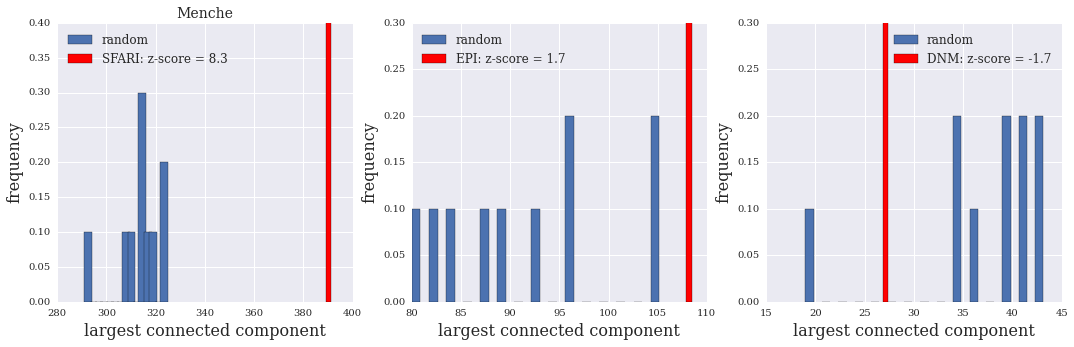

In [21]:
# plot the largest connected component of genes in SFARI (autism)
LCC_size_disease, LCC_size_rand = plotting_results.compare_LCC(set(genes_sfari),Gint,num_reps=10)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plotting_results.plot_disease_LCC(LCC_size_disease, LCC_size_rand,disease_name='SFARI')
plt.title(int_name,fontsize=14)

plt.subplot(1,3,2)
LCC_size_disease, LCC_size_rand = plotting_results.compare_LCC(set(genes_EPI),Gint,num_reps=10)
plotting_results.plot_disease_LCC(LCC_size_disease, LCC_size_rand,disease_name='EPI')

plt.subplot(1,3,3)
LCC_size_disease, LCC_size_rand = plotting_results.compare_LCC(set(genes_DNM),Gint,num_reps=10)
plotting_results.plot_disease_LCC(LCC_size_disease, LCC_size_rand,disease_name='DNM')


In the above figure we see the size of the LCC of each gene set (red bar) compared to the distribution of LCCs in the degree-preserving, edge-shuffled graphs.  If the red bar is much higher than the background distribution (z-score greater than about 3) the gene set is localized.

[TOC](#toc)

<a id='loc_SPL'></a>
### Localization: Shortest path length distributions 

calculating random set 0 out of 5
calculating random set 1 out of 5
calculating random set 2 out of 5
calculating random set 3 out of 5
calculating random set 4 out of 5
calculating random set 0 out of 5
calculating random set 1 out of 5
calculating random set 2 out of 5
calculating random set 3 out of 5
calculating random set 4 out of 5
calculating random set 0 out of 5
calculating random set 1 out of 5
calculating random set 2 out of 5
calculating random set 3 out of 5
calculating random set 4 out of 5


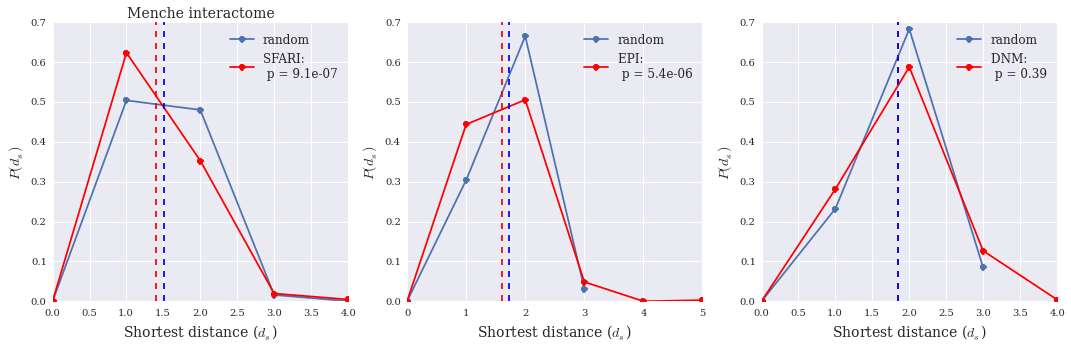

In [22]:
plt.figure(figsize=(18,5))

num_reps=5

SD_disease, SD_rand = plotting_results.compare_SD(set(genes_sfari),Gint,num_reps=num_reps)
plt.subplot(1,3,1)
plotting_results.plot_disease_localization(SD_disease,SD_rand,disease_name='SFARI')
plt.title(int_name+' interactome',fontsize=14)

SD_disease, SD_rand = plotting_results.compare_SD(set(genes_EPI),Gint,num_reps=num_reps)
plt.subplot(1,3,2)
plotting_results.plot_disease_localization(SD_disease,SD_rand,disease_name='EPI')

SD_disease, SD_rand = plotting_results.compare_SD(set(genes_DNM),Gint,num_reps=num_reps)
plt.subplot(1,3,3)
plotting_results.plot_disease_localization(SD_disease,SD_rand,disease_name='DNM')


In the figure above we see distribution of the shortest path lengths in the seed node set on the original graph, compared to the distribution of shortest path lengths in the degree-preserving, edge-shuffled graphs.  Red and blue dotted vertical lines have been drawn at the position of the distribution mean.  If the red vertical line is significantly smaller than the blue vertical line (wilcoxon-rank sum test p-value), the seed node set is localized.

[TOC](#toc)

<a id='loc_jaccard'></a>
### Localization: Jaccard similarity (following Novarino et al) 

calculating random set 0 out of 10
calculating random set 1 out of 10
calculating random set 2 out of 10
calculating random set 3 out of 10
calculating random set 4 out of 10
calculating random set 5 out of 10
calculating random set 6 out of 10
calculating random set 7 out of 10
calculating random set 8 out of 10
calculating random set 9 out of 10
calculating random set 0 out of 10
calculating random set 1 out of 10
calculating random set 2 out of 10
calculating random set 3 out of 10
calculating random set 4 out of 10
calculating random set 5 out of 10
calculating random set 6 out of 10
calculating random set 7 out of 10
calculating random set 8 out of 10
calculating random set 9 out of 10
calculating random set 0 out of 10
calculating random set 1 out of 10
calculating random set 2 out of 10
calculating random set 3 out of 10
calculating random set 4 out of 10
calculating random set 5 out of 10
calculating random set 6 out of 10
calculating random set 7 out of 10
calculating random s

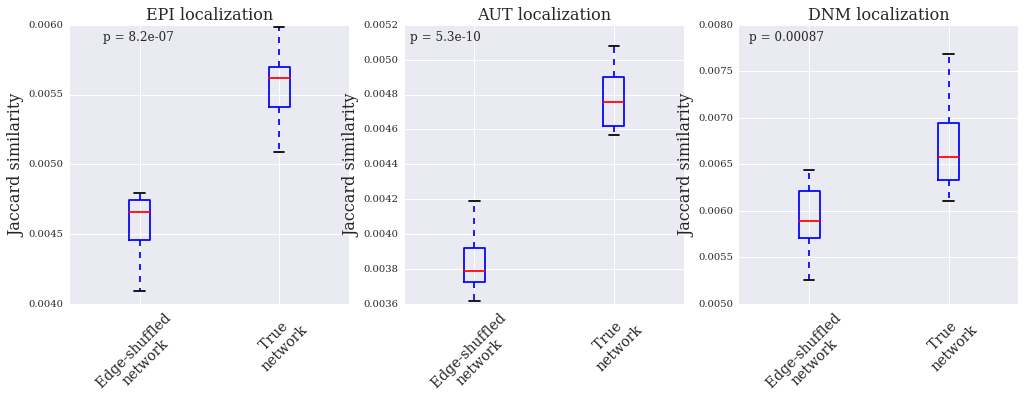

In [25]:
genes_epi_in_graph = list(np.intersect1d(Gint.nodes(),list(genes_EPI)))

num_reps = 10

focal_sim,rand_sim = localization.measure_connectivity(Gint,list(genes_epi_in_graph),num_reps=num_reps)
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.boxplot([rand_sim,focal_sim])
#U,p = scipy.stats.mannwhitneyu(rand_sim,focal_sim)
t,p = scipy.stats.ttest_ind(rand_sim,focal_sim)
psig_SE = plotting_results.nsf(p,n=2)
#plt.plot(1,focal_sim,'*',color='darkorange',markersize=16)
plt.ylabel('Jaccard similarity',fontsize=16)
plt.annotate('p = ' + str(psig_SE),
              xy=(.1,.9),xycoords='figure fraction',fontsize=12)
#plt.ylim(0,.04)
plt.xticks([1,2],['Edge-shuffled \nnetwork','True \nnetwork'],rotation=45,fontsize=14)
plt.title('EPI localization',fontsize=16)


genes_sfari_in_graph = list(np.intersect1d(Gint.nodes(),list(genes_sfari)))
focal_sim,rand_sim = localization.measure_connectivity(Gint,list(genes_sfari_in_graph),num_reps=num_reps)
plt.subplot(1,3,2)
plt.boxplot([rand_sim,focal_sim])
#U,p = scipy.stats.mannwhitneyu(rand_sim,focal_sim)
t,p = scipy.stats.ttest_ind(rand_sim,focal_sim)
psig_SE = plotting_results.nsf(p,n=2)
#plt.plot(1,focal_sim,'*',color='darkorange',markersize=16)
plt.ylabel('Jaccard similarity',fontsize=16)
plt.annotate('p = ' + str(psig_SE),
              xy=(.4,.9),xycoords='figure fraction',fontsize=12)
#plt.ylim(0,.04)
plt.xticks([1,2],['Edge-shuffled \nnetwork','True \nnetwork'],rotation=45,fontsize=14)
plt.title('ASD localization',fontsize=16)


genes_DNM_in_graph = list(np.intersect1d(Gint.nodes(),list(genes_DNM)))
focal_sim,rand_sim = localization.measure_connectivity(Gint,list(genes_DNM_in_graph),num_reps=num_reps)
plt.subplot(1,3,3)
plt.boxplot([rand_sim,focal_sim])
#U,p = scipy.stats.mannwhitneyu(rand_sim,focal_sim)
t,p = scipy.stats.ttest_ind(rand_sim,focal_sim)
psig_SE = plotting_results.nsf(p,n=2)
#plt.plot(1,focal_sim,'*',color='darkorange',markersize=16)
plt.ylabel('Jaccard similarity',fontsize=16)
plt.annotate('p = ' + str(psig_SE),
              xy=(.73,.9),xycoords='figure fraction',fontsize=12)
#plt.ylim(0,.04)
plt.xticks([1,2],['Edge-shuffled \nnetwork','True \nnetwork'],rotation=45,fontsize=14)
plt.title('DNM localization',fontsize=16)





Above we show the Jaccard similarity in neighbor sets between node pairs in each of the focal gene sets.  Gene sets are colocalized if they have a Jaccard similarity significantly higher than the baseline from the edge-shuffled graph. 

[TOC](#toc)

<a id='loc_net_prop'></a>
### Localization: Network propagation from seed nodes

In [32]:
localize_SFARI = network_prop.calc_localization(Gint,genes_sfari,num_reps=5,subsample=False)
localize_EPI = network_prop.calc_localization(Gint,genes_EPI,num_reps=5,subsample=False)
localize_DNM = network_prop.calc_localization(Gint,genes_DNM,num_reps=5,subsample=False)

0
6.73322373142e-08
6.20783494664e-08
1
6.77342853759e-08
6.17052210341e-08
2
7.01540366254e-08
6.27233105153e-08
3
6.85161670373e-08
6.34490214657e-08
4
7.09723589049e-08
6.5407601979e-08
0
1.18024015464e-07
1.11741472149e-07
1
1.21888807763e-07
1.16940383196e-07
2
1.16343977129e-07
1.08413377109e-07
3
1.21958405617e-07
1.15420135017e-07
4
1.22985525772e-07
1.15707637447e-07
0
1.81436403122e-07
1.75078219223e-07
1
1.8279008548e-07
1.75819273001e-07
2
1.69325514176e-07
1.70610811155e-07
3
1.83534485831e-07
1.77996004103e-07
4
1.64001829219e-07
1.56429620012e-07


(-0.5, 0.5)

/Users/brin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


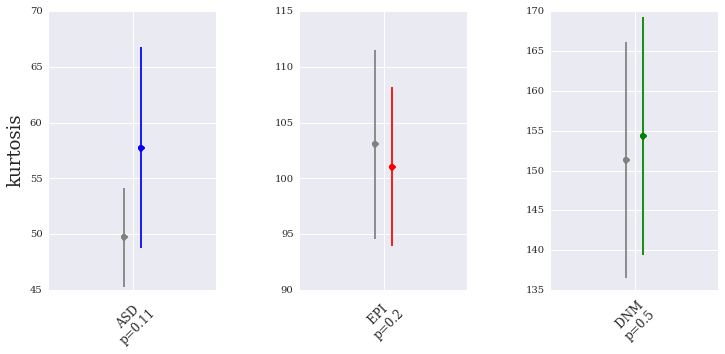

In [34]:
# plot the results

kurt_SFARI,var_SFARI,sumTop_SFARI = localize_SFARI['kurtosis'], localize_SFARI['var'], localize_SFARI['sumTop']
kurt_Srand,var_Srand,sumTop_Srand = localize_SFARI['kurt_rand'], localize_SFARI['var_rand'],localize_SFARI['sumTop_rand']
kurt_EPI,var_EPI,sumTop_EPI = localize_EPI['kurtosis'], localize_EPI['var'],localize_EPI['sumTop']
kurt_Erand,var_Erand,sumTop_Erand = localize_EPI['kurt_rand'], localize_EPI['var_rand'],localize_EPI['sumTop_rand']
kurt_DNM,var_DNM,sumTop_DNM = localize_DNM['kurtosis'], localize_DNM['var'],localize_DNM['sumTop']
kurt_Drand,var_Drand,sumTop_Drand = localize_DNM['kurt_rand'], localize_DNM['var_rand'],localize_DNM['sumTop_rand']



num_reps=localize_SFARI['num_reps']

U,p = scipy.stats.mannwhitneyu(kurt_SFARI,kurt_Srand)
psig_S = plotting_results.nsf(p,n=2)
U,p = scipy.stats.mannwhitneyu(kurt_EPI,kurt_Erand)
psig_E = plotting_results.nsf(p,n=2)
U,p = scipy.stats.mannwhitneyu(kurt_DNM,kurt_Drand)
psig_D = plotting_results.nsf(p,n=2)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.subplots_adjust(wspace=.5)
plt.errorbar(-.05,np.mean(kurt_Srand),2*np.std(kurt_Srand)/np.sqrt(num_reps),fmt='o',
             ecolor='gray',markerfacecolor='gray')
plt.errorbar(.05,np.mean(kurt_SFARI),2*np.std(kurt_SFARI)/np.sqrt(num_reps),fmt='bo')
plt.xticks([0],['ASD \np='+str(psig_S)],rotation=45,fontsize=12)
plt.ylabel('kurtosis',fontsize=18)
plt.xlim(-.5,.5)

plt.subplot(1,3,2)
plt.errorbar(-.05,np.mean(kurt_Erand),2*np.std(kurt_Erand)/np.sqrt(num_reps),fmt='o',
             ecolor='gray',markerfacecolor='gray')
plt.errorbar(.05,np.mean(kurt_EPI),2*np.std(kurt_EPI)/np.sqrt(num_reps),fmt='ro')
plt.xticks([0],['EPI \np='+str(psig_E)],rotation=45,fontsize=12)
plt.xlim(-.5,.5)

plt.subplot(1,3,3)
plt.errorbar(-.05,np.mean(kurt_Drand),2*np.std(kurt_Drand)/np.sqrt(num_reps),fmt='o',
             ecolor='gray',markerfacecolor='gray')
plt.errorbar(.05,np.mean(kurt_DNM),2*np.std(kurt_DNM)/np.sqrt(num_reps),fmt='go')
plt.xticks([0],['DNM \np='+str(psig_D)],rotation=45,fontsize=12)
plt.xlim(-.5,.5)





Above we show the kurtosis of the distribution from heat distributed from gene sets on the original graph, compared to the kurtosis from the heat distribution on the edge-shuffled graph.  If gene sets are localized, the kurtosis will be significantly higher than the baseline. 

[TOC](#toc)

<a id='gene_prioritization'></a>
# Gene prioritization: Which nodes are hot in both gene sets?

- **First build the degree-corrected version of adjacency matrix**

    Note that Wprime has been adjusted here from the original Vanunu et al version, in order to guarantee heat conservation:

    New version: Wprime(i,j) = W(i,j)/deg(i)

    Old version:  Wprime(i,j) = W(i,j)/sqrt(deg(i) x deg(j))   
    
    


- Run the network propagation algorithm starting from both seed sets

- Plot all the genes in x-y space, where x is the heat from set 1, and y is the heat from set2, so genes which are close to both input sets have high values of x _and_ y


In [35]:
# This is where the heat propagation simulation is executed
Wprime = network_prop.normalized_adj_matrix(Gint,conserve_heat=True)

seed_SFARI = list(np.intersect1d(list(genes_sfari),Gint.nodes()))
Fnew_SFARI = network_prop.network_propagation(Gint,Wprime,seed_SFARI,alpha=.5,num_its=20)
#Fnew_SFARI.sort(ascending=False)

seed_EPI = list(np.intersect1d(list(genes_EPI),Gint.nodes()))
Fnew_EPI = network_prop.network_propagation(Gint,Wprime,seed_EPI,alpha=.5,num_its=20)
#Fnew_EPI.sort(ascending=False)

seed_DNM = list(np.intersect1d(list(genes_DNM),Gint.nodes()))
Fnew_DNM = network_prop.network_propagation(Gint,Wprime,seed_DNM,alpha=.5,num_its=20)

G_temp = nx.configuration_model(Gint.degree().values())
G_rand = nx.Graph()  # switch from multigraph to digraph
G_rand.add_edges_from(G_temp.edges())
# remove self-loops
G_rand.remove_edges_from(G_rand.selfloop_edges())
G_rand = nx.relabel_nodes(G_rand,dict(zip(range(len(G_rand.nodes())),Gint.degree().keys())))
Wprime_rand = network_prop.normalized_adj_matrix(G_rand,conserve_heat=True)

# store the resulting heat vectors here
Fnew_rand_SFARI = network_prop.network_propagation(G_rand,Wprime_rand,seed_SFARI,alpha=.5,num_its=20)
Fnew_rand_EPI = network_prop.network_propagation(G_rand,Wprime_rand,seed_EPI,alpha=.5,num_its=20)
Fnew_rand_DNM = network_prop.network_propagation(G_rand,Wprime_rand,seed_DNM,alpha=.5,num_its=20)

<a id='gene_set_overlap'></a>
### Visualize the overlap in gene set membership between all three sets**

<matplotlib_venn._common.VennDiagram instance at 0x11ecb67a0>

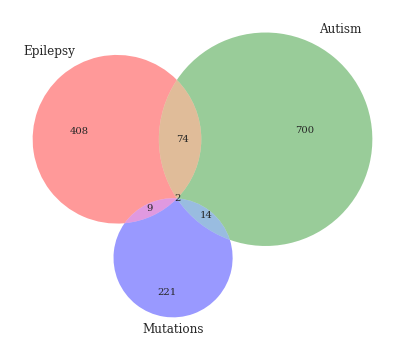

In [38]:
# overlap between all three sets
from matplotlib_venn import venn2
from matplotlib_venn import venn3

plt.figure(figsize=(7,7))
venn3([set(genes_EPI),genes_sfari,set(genes_DNM)],set_labels=['Epilepsy','Autism','Mutations'])


<a id='visualize_heat_space'></a>
## Visualize mutations in heat vector space

- Find all genes with: $H_A \cdot H_B > C$
- Mark these genes red 
- Find all Mutation genes that fall within this set (black dots above red line)


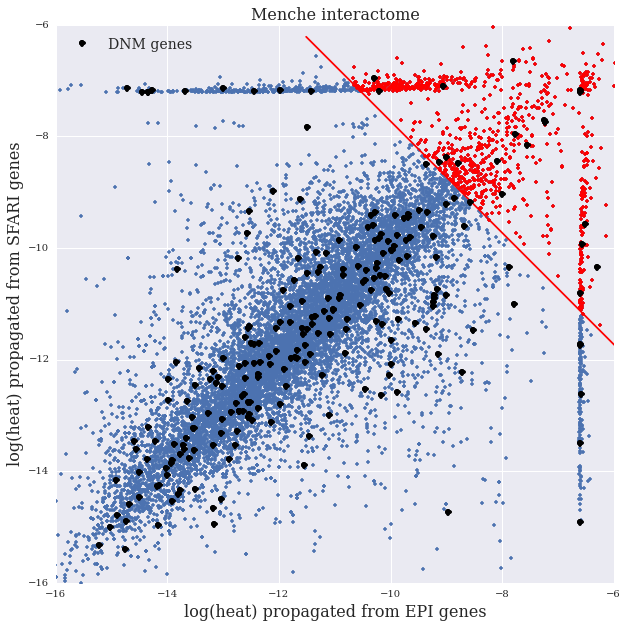

In [40]:
plt.figure(figsize=(10,10))
plt.plot(np.log(Fnew_EPI),np.log(Fnew_SFARI),'.')

# plot a line such that x*y = constant
mult_score=2E-8 #.00000001#.001
x = np.linspace(.00001,1,100)
y = mult_score/x
plt.plot(np.log(x),np.log(y),'r-')
plt.xlim(-16,-6)
plt.ylim(-16,-6)
plt.xlabel('log(heat) propagated from EPI genes',fontsize=16)
plt.ylabel('log(heat) propagated from SFARI genes', fontsize=16)

Fnew_both = Fnew_EPI*Fnew_SFARI
Fnew_both_rand = Fnew_rand_EPI*Fnew_rand_SFARI
plt.plot(np.log(Fnew_EPI[Fnew_both>mult_score]),np.log(Fnew_SFARI[Fnew_both>mult_score]),'r.')
plt.plot(np.log(Fnew_EPI[seed_DNM]),np.log(Fnew_SFARI[seed_DNM]),'ko',label='DNM genes')
plt.legend(loc='best',fontsize=14)
plt.title(int_name + ' interactome',fontsize=16)


[TOC](#toc)

### Print out which genes from the mutation set are likely related to both input gene sets

In [42]:
genes_G_multscore = list(Fnew_both[Fnew_both>mult_score].index)
len(genes_G_multscore)
hot_genes_DNM = list(np.intersect1d(genes_G_multscore,list(seed_DNM)))

hot_genes_DNM_sfari = list(np.intersect1d(hot_genes_DNM,list(genes_sfari)))
hot_genes_DNM_sfari = list(np.setdiff1d(hot_genes_DNM_sfari,genes_EPI))

DNM_gs = mg.querymany(hot_genes_DNM_sfari,scopes='entrezgene',fields='symbol',species='human')
DNM_hot_symbol = [str(x['symbol']) for x in DNM_gs]
print('\ngenes known only from SFARI also hot in DNM:')
for g in DNM_hot_symbol:
    print(g)

hot_genes_DNM_EPI = list(np.intersect1d(hot_genes_DNM,list(genes_EPI)))
hot_genes_DNM_EPI = list(np.setdiff1d(hot_genes_DNM_EPI,list(genes_sfari)))

DNM_gs = mg.querymany(hot_genes_DNM_EPI,scopes='entrezgene',fields='symbol',species='human')
DNM_hot_symbol = [str(x['symbol']) for x in DNM_gs]
print('\ngenes known only from EPI also hot in DNM:')
for g in DNM_hot_symbol:
    print(g)
    
hot_genes_DNM_both = list(np.intersect1d(hot_genes_DNM,list(genes_EPI)))
hot_genes_DNM_both = list(np.intersect1d(hot_genes_DNM_both,list(genes_sfari)))

DNM_gs = mg.querymany(hot_genes_DNM_both,scopes='entrezgene',fields='symbol',species='human')
DNM_hot_symbol = [str(x['symbol']) for x in DNM_gs]
print('\ngenes known from both EPI and SFARI, also hot in DNM:')
for g in DNM_hot_symbol:
    print(g)
    
hot_genes_DNM_neither = list(np.setdiff1d(hot_genes_DNM,list(genes_EPI)))
hot_genes_DNM_neither = list(np.setdiff1d(hot_genes_DNM_neither,list(genes_sfari)))

DNM_gs = mg.querymany(hot_genes_DNM_neither,scopes='entrezgene',fields='symbol',species='human')
DNM_hot_symbol = [str(x['symbol']) for x in DNM_gs]
print('\ngenes known from neither EPI nor SFARI, but are hot in DNM:')
for g in DNM_hot_symbol:
    print(g)



querying 1-4...done.
Finished.

genes known only from SFARI also hot in DNM:
EP300
NLGN1
BIN1
APH1A
querying 1-4...done.
Finished.

genes known only from EPI also hot in DNM:
PNKP
CSMD2
KCNB1
RHOG
querying 1-2...done.
Finished.

genes known from both EPI and SFARI, also hot in DNM:
AMT
CDKL5
querying 1-9...done.
Finished.

genes known from neither EPI nor SFARI, but are hot in DNM:
AP2M1
TUBB
GABRA2
KCNJ16
TRIM27
STK11
TRAF1
TRAF2
TRAF6


<a id='zscore_gene_prioritization'></a>
## Measure the distribution of heat from nodes on original network, compared to edge-shuffled network

- Is a node’s heat significantly different from background?  
- Compute z-score of true heat to edge-shuffled heat.  
- Rank by product of z-scores.  


In [43]:
# this function plots the heat distribution from seed set, compared to edge-shuffled network
def plot_heat_distributions(seed_nodes,Gint,focal_name='EPI'):
    
    seed_nodes = list(np.intersect1d(list(seed_nodes),Gint.nodes()))
    Fnew = network_prop.network_propagation(Gint,Wprime,seed_nodes,alpha=.5,num_its=20)
    genes_not_seed = np.setdiff1d(list(Fnew.index),seed_nodes)

    G_rand = nx.configuration_model(Gint.degree().values())
    G_rand = nx.relabel_nodes(G_rand,dict(zip(range(len(G_rand.nodes())),Gint.degree().keys())))
    Wprime_rand = network_prop.normalized_adj_matrix(G_rand)
    Fnew_rand = network_prop.network_propagation(G_rand,Wprime_rand,seed_nodes,alpha=.5,num_its=20)
    
    xplot = np.linspace(-16,-6,15)

    plt.figure(figsize=(7,5))
    n,x = np.histogram(np.log(Fnew[Fnew>1E-16]),xplot)
    n = n/float(sum(n))
    plt.plot(xplot[:-1],n,'r.-',label='original')
    plt.title(focal_name + ' genes not in seed set',fontsize=16)

    n,x = np.histogram(np.log(Fnew_rand[Fnew_rand>1E-16]),xplot)
    n = n/float(sum(n))
    plt.plot(xplot[:-1],n,'b.-',label='edge-shuffled')
    
    plt.xlabel('log(heat)',fontsize=14)
    plt.ylabel('frequency',fontsize=14)
    plt.legend(loc='best',fontsize=12)

### Measure the heat of nodes on original network, compared to edge-shuffled network

In [44]:
seed_SFARI = list(np.intersect1d(list(genes_sfari),Gint.nodes()))
Fnew_SFARI = network_prop.network_propagation(Gint,Wprime,seed_SFARI,alpha=.5,num_its=20)

seed_EPI = list(np.intersect1d(list(genes_EPI),Gint.nodes()))
Fnew_EPI = network_prop.network_propagation(Gint,Wprime,seed_EPI,alpha=.5,num_its=20)

#Fnew_SFARI.sort(ascending=False)

num_reps=20 # Note should increase this to ~ 200
Fnew_rand_SFARI = np.zeros([num_reps,len(Fnew_SFARI)])
Fnew_rand_EPI = np.zeros([num_reps,len(Fnew_EPI)])
for r in range(num_reps):
    print(r)
    G_temp = nx.configuration_model(Gint.degree().values())
    G_rand = nx.Graph()  # switch from multigraph to digraph
    G_rand.add_edges_from(G_temp.edges())
    # remove self-loops
    G_rand.remove_edges_from(G_rand.selfloop_edges())
    G_rand = nx.relabel_nodes(G_rand,dict(zip(range(len(G_rand.nodes())),Gint.degree().keys())))
    Wprime_rand = network_prop.normalized_adj_matrix(G_rand)
    Fnew_rand_tmp = network_prop.network_propagation(G_rand,Wprime_rand,seed_SFARI,alpha=.5,num_its=20)
    Fnew_rand_SFARI[r] = Fnew_rand_tmp
    
    Fnew_rand_tmp = network_prop.network_propagation(G_rand,Wprime_rand,seed_EPI,alpha=.5,num_its=20)
    Fnew_rand_EPI[r] = Fnew_rand_tmp
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [45]:
# transform both SFARI and EPI axes to z-score space, by subtracting the mean and dividing by the standard deviation
z_score_SFARI = (Fnew_SFARI-np.mean(Fnew_rand_SFARI,axis=0))/np.std(Fnew_rand_SFARI,axis=0)
z_score_EPI = (Fnew_EPI-np.mean(Fnew_rand_EPI,axis=0))/np.std(Fnew_rand_EPI,axis=0)

In [69]:
idx_SFARI_sort = np.argsort(list(z_score_SFARI))
idx_SFARI_sort = idx_SFARI_sort[::-1]
Fnew_SFARI_reindex = Fnew_SFARI
Fnew_SFARI_reindex.index = range(len(Fnew_SFARI))
top_100_SFARI = Fnew_SFARI_reindex[idx_SFARI_sort[0:50]]
top_100_SFARI_rand = Fnew_rand_SFARI[:,idx_SFARI_sort[0:50]]
entrez_map = dict(zip(range(len(Fnew_SFARI)),list(Fnew_SFARI.index)))
entrez_top_genes = [entrez_map[x] for x in idx_SFARI_sort[0:50]]
entrez_top_genes
symbol_temp = mg.getgenes(entrez_top_genes)
symbol_top_genes = [str(x['symbol']) for x in symbol_temp if 'symbol' in x.keys()]


querying 1-50...done.


<a id='zscore_plot'></a>
### Now plot the mutated genes in z-score transformed heat vector space

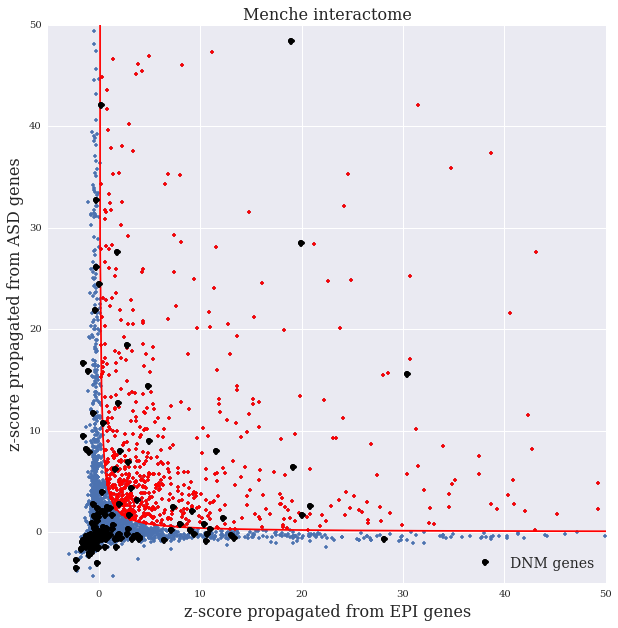

In [48]:
# plot the hot subnetwork
plt.figure(figsize=(10,10))
plt.plot((z_score_EPI),(z_score_SFARI),'.')

plt.xlim(-5,50)
plt.ylim(-5,50)
plt.xlabel('z-score propagated from EPI genes',fontsize=16)
plt.ylabel('z-score propagated from ASD genes', fontsize=16)

# plot a line such that x*y = constant
mult_score=2*2
x = np.linspace(.0001,140,1000)
y = mult_score/x
plt.plot(x,y,'r-')

z_score_both = z_score_EPI*z_score_SFARI*(z_score_EPI>0)*(z_score_SFARI>0)
plt.plot((z_score_EPI[z_score_both>mult_score]),(z_score_SFARI[z_score_both>mult_score]),'r.')
plt.plot((z_score_EPI[seed_DNM]),(z_score_SFARI[seed_DNM]),'ko',label='DNM genes')

plt.legend(loc='best',fontsize=14)
plt.title(int_name + ' interactome',fontsize=16)




[TOC](#toc)

### Which genes from the mutation list score highly in z-score space?

In [49]:
genes_G_multscore = list(z_score_both[z_score_both>mult_score].index)
len(genes_G_multscore)
hot_genes_DNM = list(np.intersect1d(genes_G_multscore,list(genes_DNM)))

hot_genes_DNM_sfari = list(np.intersect1d(hot_genes_DNM,list(genes_sfari)))
hot_genes_DNM_sfari = list(np.setdiff1d(hot_genes_DNM_sfari,genes_EPI))

DNM_gs = mg.querymany(hot_genes_DNM_sfari,scopes='entrezgene',fields='symbol',species='human')
DNM_hot_symbol = [str(x['symbol']) for x in DNM_gs]
print('\ngenes known only from SFARI also hot in DNM:')
for g in DNM_hot_symbol:
    print(g)

hot_genes_DNM_EPI = list(np.intersect1d(hot_genes_DNM,list(genes_EPI)))
hot_genes_DNM_EPI = list(np.setdiff1d(hot_genes_DNM_EPI,list(genes_sfari)))

DNM_gs = mg.querymany(hot_genes_DNM_EPI,scopes='entrezgene',fields='symbol',species='human')
DNM_hot_symbol = [str(x['symbol']) for x in DNM_gs]
print('\ngenes known only from EPI also hot in DNM:')
for g in DNM_hot_symbol:
    print(g)
    
hot_genes_DNM_both = list(np.intersect1d(hot_genes_DNM,list(genes_EPI)))
hot_genes_DNM_both = list(np.intersect1d(hot_genes_DNM_both,list(genes_sfari)))

DNM_gs = mg.querymany(hot_genes_DNM_both,scopes='entrezgene',fields='symbol',species='human')
DNM_hot_symbol = [str(x['symbol']) for x in DNM_gs]
print('\ngenes known from both EPI and SFARI, also hot in DNM:')
for g in DNM_hot_symbol:
    print(g)
    
hot_genes_DNM_neither = list(np.setdiff1d(hot_genes_DNM,list(genes_EPI)))
hot_genes_DNM_neither = list(np.setdiff1d(hot_genes_DNM_neither,list(genes_sfari)))

DNM_gs = mg.querymany(hot_genes_DNM_neither,scopes='entrezgene',fields='symbol',species='human')
DNM_hot_symbol = [str(x['symbol']) for x in DNM_gs]
print('\ngenes known from neither EPI nor SFARI, but are hot in DNM:')
for g in DNM_hot_symbol:
    print(g)



querying 1-2...done.
Finished.

genes known only from SFARI also hot in DNM:
EP300
BIN1
querying 1-4...done.
Finished.

genes known only from EPI also hot in DNM:
PNKP
CSMD2
KCNB1
MYH6
querying 1-2...done.
Finished.

genes known from both EPI and SFARI, also hot in DNM:
AMT
CDKL5
querying 1-25...done.
Finished.

genes known from neither EPI nor SFARI, but are hot in DNM:
MED8
AP3S1
CLCA1
TUBB
EPB42
FOXO3
ZFYVE26
GH1
HIPK2
BLNK
PACSIN3
IGKC
ARHGDIA
MYH2
MYH9
C19orf66
KIR2DL5A
RFC3
RFC4
TRIM27
TMEM135
AURKA
TRAF6
ATRIP
ACAD11


[TOC](#toc)


<a id='prep_results_file'></a>
### Prep results file for output (ranked list of genes by combined heat)

In [57]:
# make a column for if the zscore is greater than a threshold
zscore_thresh =5*5
zscore_greater_threshold = z_score_both>zscore_thresh

# make a column for if heat is greater than a threshold
heat_thresh = 10E-8
heat_greater_threshold = Fnew_both>heat_thresh

# make a column with the mutation counts in de novo genes
DNM_counts = pd.Series(0,index=list(z_score_both.index))
DNM_index = list(np.intersect1d(DNM_value_counts.index,z_score_both.index))
DNM_counts[DNM_index] = DNM_value_counts[DNM_index]

# make columns denoting if gene was in seed sets
in_EPI = pd.Series(index=list(z_score_both.index))
in_EPI[list(z_score_both.index)] = False
in_EPI[seed_EPI]=True

in_SFARI = pd.Series(index=list(z_score_both.index))
in_SFARI[list(z_score_both.index)] = False
in_SFARI[seed_SFARI]=True

in_DNM = pd.Series(index=list(z_score_both.index))
in_DNM[list(z_score_both.index)] = False
in_DNM[seed_DNM]=True

genes_heat_df = pd.DataFrame({'entrez_id':list(z_score_both.index),'zscore_combined':z_score_both,
                              'zscore_greater_thresh':zscore_greater_threshold,
                              'heat_combined':Fnew_both, 'heat_greater_thresh':heat_greater_threshold,
                              'in_SFARI':in_SFARI,'in_EPI':in_EPI,'in_DNM':in_DNM,
                              'DNM_counts':DNM_counts},index=list(z_score_both.index))
genes_heat_df.sort(columns='zscore_combined',ascending=False,inplace=True)
genes_heat_df.head(25)

,DNM_counts,entrez_id,heat_combined,heat_greater_thresh,in_DNM,in_EPI,in_SFARI,zscore_combined,zscore_greater_thresh
2566,0,2566,1.054365e-07,True,False,True,False,955588.937085,True
144165,0,144165,1.062807e-06,True,False,True,True,55794.890160,True
1293,0,1293,2.135682e-08,False,False,True,False,45575.417474,True
8772,0,8772,2.319432e-08,False,False,False,False,25199.812671,True
2620,0,2620,1.013864e-06,True,False,True,True,18545.539232,True
1742,0,1742,2.632707e-06,True,False,False,True,12024.019580,True
1746,0,1746,2.226287e-08,False,False,False,True,9171.061453,True
7273,0,7273,1.154558e-06,True,False,True,True,8595.261832,True
4988,0,4988,1.147693e-06,True,False,True,True,7934.352226,True
1741,0,1741,4.495364e-07,True,False,False,False,6735.605747,True


In [58]:
# save file here if desired
genes_heat_df.to_csv('gene_prioritization_example.csv',index=False,sep='\t')

[TOC](#toc)

<a id='visualize_hot_subnetwork'></a>
# Step 6: Visualize the hot subnetwork

In [59]:
rankBy = 'zscore'  # choose how to select the subnetwork.  rankBy can be either 'heat' or 'zscore'

high_zscore_nodes = list(zscore_greater_threshold[zscore_greater_threshold].index)
high_heat_nodes = list(zscore_greater_threshold[heat_greater_threshold].index)

if rankBy=='heat':
    hot_nodes = high_heat_nodes
elif rankBy=='zscore':
    hot_nodes = high_zscore_nodes

hot_nodes.extend(seed_DNM)
hot_nodes = list(np.unique(hot_nodes))

# find largest connected component
G_hot = nx.subgraph(Gint,hot_nodes)
sub_graphs = sorted(nx.connected_component_subgraphs(G_hot),key=len,reverse=True)
sub_graphs[0].nodes()
max_CC = max(nx.connected_component_subgraphs(G_hot), key=len)

hot_nodes = []

i = 0
Gtemp = sub_graphs[i]
while ((len(Gtemp.nodes())>2) and (i+1<len(sub_graphs))):
    print(i)
    hot_nodes.extend(Gtemp.nodes())
    i=i+1
    Gtemp = sub_graphs[i]


len(hot_nodes)

0


521

In [60]:
# here we pull out some useful subgraphs for plotting the hot subnetwork

d1name = 'ASD' # set the name for gene set 1
d2name='EPI'  # set the name for gene set 2
d3name = 'DNM'  # set the name for gene set 3
genes_1 = seed_SFARI  # set gene set 1
genes_2 = seed_EPI  # set gene set 2
genes_3 = seed_DNM  # set gene set 3


# Find the hot subnetwork (consisting of all nodes and connections in 'high_heat_nodes')
G_neigh_500 = Gint.subgraph(high_heat_nodes)
nx.set_node_attributes(G_neigh_500,'zscore',dict(z_score_both[G_neigh_500.nodes()]))
nx.set_node_attributes(G_neigh_500,'heat',dict(Fnew_both[G_neigh_500.nodes()]))

# pull out some useful subgraphs for use in plotting functions
# find genes which are neighbors of seed genes
genes1_in_graph = list(np.intersect1d(Gint.nodes(),list(genes_1)))
genes2_in_graph = list(np.intersect1d(Gint.nodes(),list(genes_2)))
genes3_in_graph = list(np.intersect1d(Gint.nodes(),list(genes_3)))
G_1=G_neigh_500.subgraph(list(genes1_in_graph))
G_2=G_neigh_500.subgraph(list(genes2_in_graph))
G_3=G_neigh_500.subgraph(list(genes3_in_graph))
g1_g2_in_graph = []
g1_g2_in_graph.extend(list(genes1_in_graph))
g1_g2_in_graph.extend(list(genes2_in_graph))
G_1_2 = G_neigh_500.subgraph(g1_g2_in_graph)

In [61]:
# transform the z-score and heat vectors for better plotting

z_score_transf = np.sqrt(np.abs(z_score_both))*7
z_score_transf = [np.max([x,20])*1.2 for x in z_score_transf]
z_score_transf = [np.min([x,200])*1.2 for x in z_score_transf]
z_score_transf = pd.Series(z_score_transf,index=list(z_score_both.index))


heat_transf = np.log(Fnew_both)
heat_transf = (heat_transf+17)*70
heat_transf = [np.max([x,20]) for x in heat_transf]
heat_transf = [np.min([x,200]) for x in heat_transf]
heat_transf = pd.Series(heat_transf,index=list(Fnew_both.index))
heat_transf.head(20)

if rankBy=='heat':
    transfBy = heat_transf
elif rankBy=='zscore':
    transfBy = z_score_transf

In [62]:
# what are the names of the hottest genes?

hot_500 = [G_neigh_500.nodes(data=True)[i][1][rankBy] for i in range(len(G_neigh_500.nodes()))]
hot_500 = pd.Series(hot_500,index=G_neigh_500.nodes())
hot_500.sort(ascending=False)
top_10 = list(hot_500.head(20).index)
top_10_GS = mg.querymany(top_10,scopes='entrezgene',fields='symbol',species='human')

top_10_symbol = [x['symbol'] for x in top_10_GS]

for s in top_10_symbol:
    print(s)


querying 1-20...done.
Finished.
GABRG2
PRICKLE1
GAS2
DLG4
TTN
OPRM1
DLG3
CAMK4
PRKCI
CDKL5
ABL1
CALM2
APP
MEF2C
AMT
CRK
SCN1A
PTEN
EP300
KCNMA1


In [63]:
pos = nx.spring_layout(G_neigh_500,k=.6,scale=10)  # set the node positions

/Users/brin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


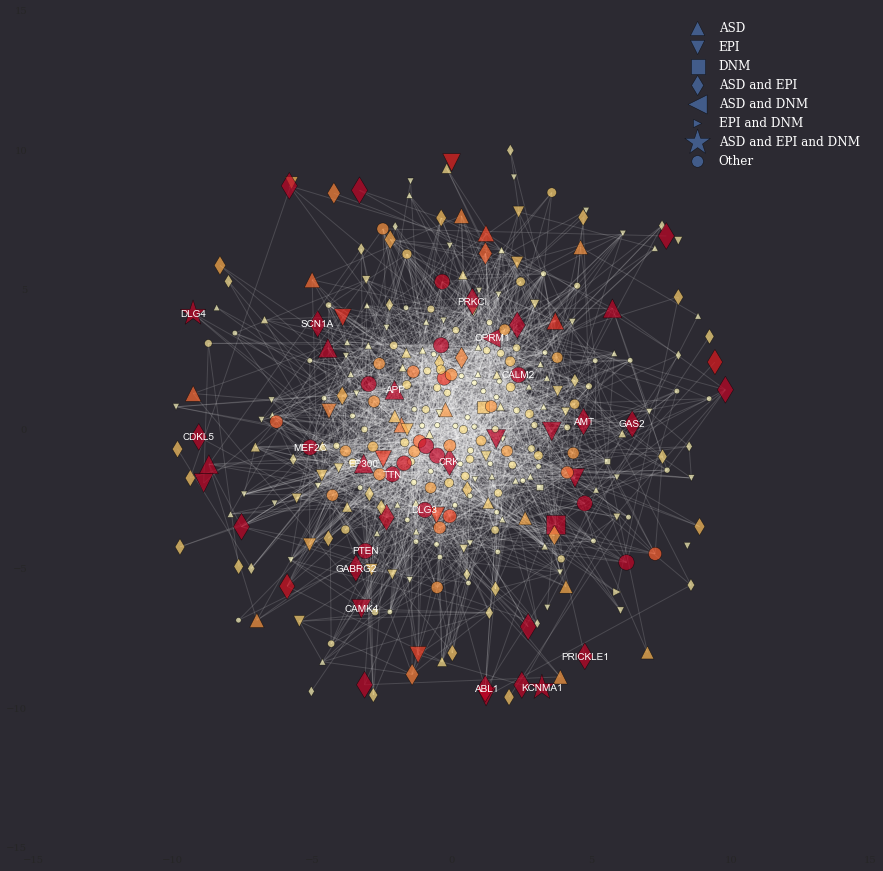

In [64]:
fig = plt.figure(figsize=(15,15),facecolor='#2C2A32')
axes = fig.add_subplot(1, 1, 1, axisbg='#2C2A32')
# create lists of nodes for plotting
nodes_3 = list(np.intersect1d(G_1.nodes(),G_2.nodes()))
nodes_3 = list(np.intersect1d(nodes_3,G_3.nodes()))

nodes_only_1 = list(np.setdiff1d(G_1.nodes(),genes_2))
nodes_only_1 = list(np.setdiff1d(nodes_only_1,genes_3))

nodes_12 = list(np.intersect1d(G_1.nodes(),G_2.nodes()))
nodes_12 = list(np.setdiff1d(nodes_12,nodes_3))

nodes_13 = list(np.intersect1d(G_1.nodes(),G_3.nodes()))
nodes_13 = list(np.setdiff1d(nodes_13,nodes_3))

nodes_23 = list(np.intersect1d(G_2.nodes(),G_3.nodes()))
nodes_23 = list(np.setdiff1d(nodes_23,nodes_3))

nodes_only_2 = list(np.setdiff1d(G_2.nodes(),genes_1))
nodes_only_2 = list(np.setdiff1d(nodes_only_2,genes_3))

nodes_only_3 = list(np.setdiff1d(G_3.nodes(),genes_1))
nodes_only_3 = list(np.setdiff1d(nodes_only_3,genes_2))

nodes_other = list(np.setdiff1d(G_neigh_500.nodes(),nodes_only_1))
nodes_other = list(np.setdiff1d(nodes_other,nodes_only_2))
nodes_other = list(np.setdiff1d(nodes_other,nodes_only_3))
nodes_other = list(np.setdiff1d(nodes_other,nodes_12))
nodes_other = list(np.setdiff1d(nodes_other,nodes_13))
nodes_other = list(np.setdiff1d(nodes_other,nodes_23))
nodes_other = list(np.setdiff1d(nodes_other,nodes_3)) 

cmap = 'YlOrRd'
vmin=20
vmax=275

nx.draw_networkx_nodes(G_neigh_500, nodelist=nodes_only_1,alpha=.7,
                       linewidths=.5,node_shape='^',node_size=transfBy[nodes_only_1]*1.5,pos=pos,
                       node_color=transfBy[nodes_only_1],cmap=cmap,with_labels=False,label=d1name,vmin=vmin,vmax=vmax)
nx.draw_networkx_nodes(G_neigh_500, nodelist=nodes_only_2,alpha=.7,
                       linewidths=.5,node_shape='v',node_size=transfBy[nodes_only_2]*1.5,pos=pos,
                       node_color=transfBy[nodes_only_2],cmap=cmap,with_labels=False,label=d2name,vmin=vmin,vmax=vmax)
nx.draw_networkx_nodes(G_neigh_500, nodelist=nodes_only_3,alpha=.7,
                       linewidths=.5,node_shape='s',node_size=transfBy[nodes_only_3]*1.5,pos=pos,
                       node_color=transfBy[nodes_only_3],cmap=cmap,with_labels=False,label=d3name,vmin=vmin,vmax=vmax)
nx.draw_networkx_nodes(G_neigh_500, nodelist=nodes_12,alpha=.7,
                       linewidths=.5,node_shape='d',node_size=transfBy[nodes_12]*1.5,pos=pos,
                       node_color=transfBy[nodes_12],cmap=cmap,with_labels=False,
                       label=d1name + ' and ' + d2name,vmin=vmin,vmax=vmax)
nx.draw_networkx_nodes(G_neigh_500, nodelist=nodes_13,alpha=.7,
                       linewidths=.5,node_shape='<',node_size=transfBy[nodes_13]*1.5,pos=pos,
                       node_color=transfBy[nodes_13],with_labels=False,cmap=cmap,
                       label=d1name + ' and ' +  d3name,
                       vmin=vmin,vmax=vmax)
nx.draw_networkx_nodes(G_neigh_500, nodelist=nodes_23,alpha=.7,
                       linewidths=.5,node_shape='>',node_size=transfBy[nodes_23]*1.5,pos=pos,
                       node_color=transfBy[nodes_23],with_labels=False,cmap=cmap,
                       label=d2name + ' and ' + d3name,
                       vmin=vmin,vmax=vmax)
nx.draw_networkx_nodes(G_neigh_500, nodelist=nodes_3,alpha=.7,
                       linewidths=.5,node_shape='*',node_size=transfBy[nodes_3]*3,pos=pos,
                       node_color=transfBy[nodes_3],with_labels=False,cmap=cmap,
                       label=d1name + ' and ' +  d2name + ' and ' + d3name,
                       vmin=vmin,vmax=vmax)
nx.draw_networkx_nodes(G_neigh_500, nodelist=nodes_other,alpha=.7,
                       linewidths=.5,node_shape='o',node_size=transfBy[nodes_other],pos=pos,
                       node_color=transfBy[nodes_other],cmap=cmap,with_labels=False,label='Other',
                       vmin=vmin,vmax=vmax)

#nx.draw_networkx_nodes(G_neigh_500,pos=pos,node_color=z_score_both[G_neigh_500.nodes()],cmap='YlOrRd',node_size=30,
#                  vmin=0,vmax=100)
nx.draw_networkx_edges(G_neigh_500,pos=pos,edge_color='white',alpha=.15)

G_top10 = G_neigh_500.subgraph(top_10)
nx.draw_networkx_labels(G_top10,pos=pos,font_color='white',font_size=10,
                        labels = dict(zip(G_top10.nodes(),top_10_symbol)))
#nx.draw_networkx_labels(G_neigh_500,pos=pos,font_color='white')

plt.grid('off')
leg = plt.legend(fontsize=12,loc='best')
for text in leg.get_texts():
    plt.setp(text, color = 'w')
    
#plt.savefig('SFARI_EPI_network_LCC_heat.png',dpi=300,bbox_inches='tight')

<a id='hot_GO'></a>
### Is this hot subnetwork significantly enriched for any GO terms?

- This may provide clues to function of genes involved in both gene sets

In [4]:
# import GO annotation tools (this takes a little time)

import sys
sys.path.append('../source/go_annotation')
from HypergeomCalculator import *

go_gene_file = '../source/go_annotation/GO2all_locus.txt'
gene_info_file = '../source/go_annotation/Homo_sapiens.gene_info'
go_term_file = '../source/go_annotation/go.obo'
GO_ID_list, total_unique_gene, GO_Term_list = GOLocusParser.parse(go_gene_file, gene_info_file, go_term_file)

14169:18636:44082


In [69]:
# what is the enrichment of top hot genes?
focal_group = list(hot_nodes)
# print out top 5 GO annotations with q-value>10 for this gene set:
if len(focal_group)>20:  # only calculate enrichment if more than 20 nodes in set
    # first translate focal_group to gene names from entrezIDs
    focal_temp = mg.getgenes(focal_group)
    focal_gene_names = [str(x['symbol']) for x in focal_temp if 'symbol' in x.keys()]
    enriched_list = calc_enrichment(focal_gene_names, GO_ID_list, total_unique_gene, GO_Term_list)
    i=0
    if len(enriched_list)>0:  # if there are any significant matches, print them
        qtemp = enriched_list[i]['qvalue']
    else:  
        qtemp=0
        print('no significant matches')
    while (qtemp>5) and (i<6):
        print(enriched_list[i]['name'] + ': q-value = ' + str(enriched_list[i]['qvalue']))

        # update i and qtemp
        i = i+1
        qtemp = enriched_list[i]['qvalue']
else:
    print('focal community is too small')

querying 1-521...done.
enzyme linked receptor protein signaling pathway: q-value = 37.3256098598
cellular response to growth factor stimulus: q-value = 33.6018540395
response to growth factor: q-value = 33.5397333063
transmembrane receptor protein tyrosine kinase signaling pathway: q-value = 33.346540997
neurogenesis: q-value = 32.5700776086
phosphorylation: q-value = 32.3507663736


[TOC](#toc)